In [1]:
import random
import time
import pickle
import pandas as pd
import numpy as np
import re

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
from sklearn.decomposition import PCA
import scikitplot as skplt
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data.csv')
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text    = re.sub(pattern, ' ', x)
    return text

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
        x = re.sub('[0-9]{1}', '#', x)
    return x

from mapping import *

def normalization(text):
    pattern = re.compile(r'\b(' + '|'.join(mapping.keys()) + r')\b')
    return pattern.sub(lambda x: mapping[x.group()], text)

# lower the text
data['review'] = data['review'].apply(lambda x: x.lower())

# Clean the text
data['review'] = data['review'].apply(lambda x: clean_text(x))

# Clean numbers
data['review'] = data['review'].apply(lambda x: clean_numbers(x))

# normalization
data['review'] = data['review'].apply(lambda x: normalization(x))

X = data['review']
y = data['label']

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(X))
X = tokenizer.texts_to_sequences(X)

# padding
X = pad_sequences(X, maxlen=150)

# label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y.values)

# Word embedding
with open('fasttext.pickle', 'rb') as handle:
    embedding_matrix = pickle.load(handle)

In [11]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
kf = KFold(n_splits=5)
max_features = 12000
embed_size = 300
n_classes = len(le.classes_)
n_epochs = 4
drop_prob = 0.4
learning_rate = 0.001

In [4]:
# custom
hidden_size = 256
n_layers = 1
batch_size = 32

In [5]:
class RNNLSTM(nn.Module):
    
    def __init__(self):
        super(RNNLSTM, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        # RNN Layer
        self.rnn= nn.LSTM(embed_size, hidden_size, n_layers, bidirectional= True, dropout=0.1)
        
        # hidden layer linear transformation
        self.fc = nn.Linear(hidden_size*4 , 64)   
        # fungsi aktivasi
        self.relu = nn.ReLU()
        
        # Droupout layer
        self.dropout = nn.Dropout(drop_prob)
        
        # Output layer
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        out_embedding = self.embedding(x)
        out_rnn, _ = self.rnn(out_embedding)
        # pooling operation
        avg_pool = torch.mean(out_rnn, 1)
        max_pool,_ = torch.max(out_rnn, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        
        conc = self.relu(self.fc(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        
        # return final output
        return out
    
model = RNNLSTM()
print(model)

RNNLSTM(
  (embedding): Embedding(12000, 300)
  (rnn): LSTM(300, 256, dropout=0.1, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (out): Linear(in_features=64, out_features=4, bias=True)
)




==========================FOLD 1==========================

Epoch 1/4 	 loss=37.8823 	 val_loss=30.5562 	 train_acc=0.4752  	 val_acc=0.6680  	 time=136.19s
Epoch 2/4 	 loss=22.9354 	 val_loss=21.0049 	 train_acc=0.7383  	 val_acc=0.7544  	 time=157.30s
Epoch 3/4 	 loss=14.9581 	 val_loss=17.9590 	 train_acc=0.8420  	 val_acc=0.7806  	 time=195.46s
Epoch 4/4 	 loss=10.4051 	 val_loss=15.9387 	 train_acc=0.9046  	 val_acc=0.8058  	 time=198.00s

                    precision    recall  f1-score   support

             Akun       0.76      0.85      0.80       184
         Aplikasi       0.76      0.80      0.78       311
Layanan Pelanggan       0.89      0.79      0.84       443
        Transaksi       0.73      0.80      0.76        92

         accuracy                           0.81      1030
        macro avg       0.78      0.81      0.80      1030
     weighted avg       0.81      0.81      0.81      1030



==========================FOLD 2==========================

Epoch 1/4 	

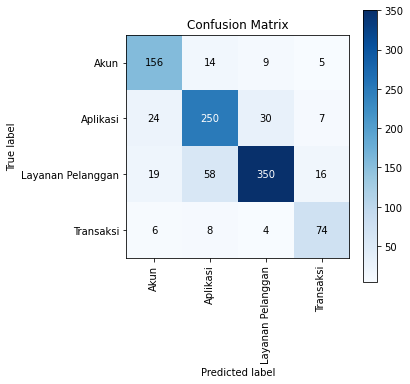

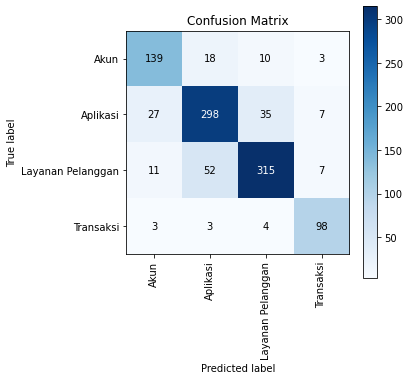

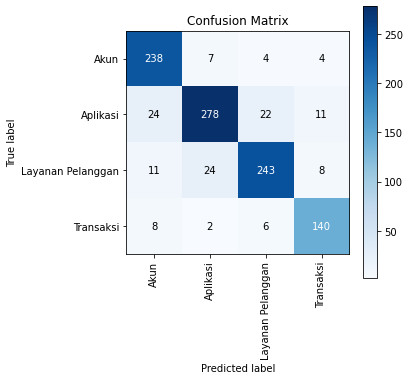

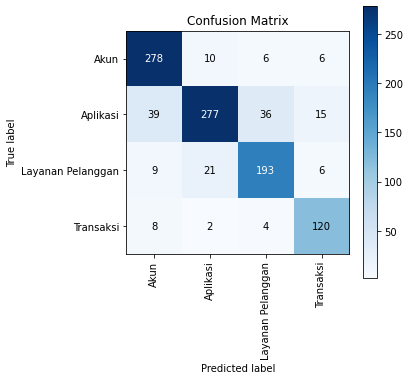

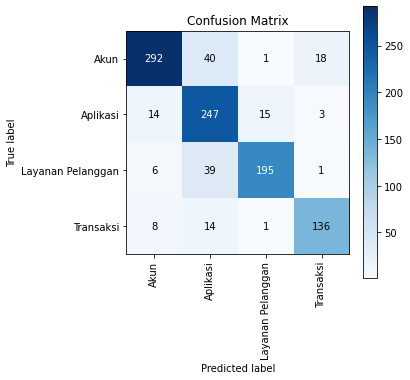

In [6]:
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=0.015)
final_acc=0
f=1
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
acc_final = []

# looping untuk 5 fold cross validation
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):

    model.embedding.reset_parameters()
    model.rnn.reset_parameters()
    model.fc.reset_parameters()
    
    # mengubah data dalam bentuk tensor
    train_x = torch.tensor(X[train_index], dtype=torch.long)
    train_y = torch.tensor(y[train_index], dtype=torch.long)
    x_cv = torch.tensor(X[test_index], dtype=torch.long)
    y_cv = torch.tensor(y[test_index], dtype=torch.long)

    # Membuat Torch datasets
    train = torch.utils.data.TensorDataset(train_x, train_y)
    valid = torch.utils.data.TensorDataset(x_cv, y_cv)

    # Membuat Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    print('\n\n==========================FOLD '+str(f)+'==========================\n')
    
    # looping untuk pelatihan
    for epoch in range(n_epochs):
        start_time = time.time()
        
        ###---TRAINING---###
        model.train()
        avg_loss = 0.
        train_preds = np.zeros((len(train_x),len(le.classes_)))
        
        for i, (x_batch, y_batch) in enumerate(train_loader):
            # Predict/Forward Pass
            y_pred = model(x_batch)
            
            # menghitung loss
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
            train_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().detach().numpy()
            
        # train accuracy
        train_accuracy = sum(train_preds.argmax(axis=1)==y[train_index])/len(y[train_index])
    
    
        ###---VALIDATION---###   
        model.eval()        
        avg_val_loss = 0.
        val_preds = np.zeros((len(x_cv),len(le.classes_)))

        for i, (x_batch, y_batch) in enumerate(valid_loader):
            y_pred = model(x_batch).detach()
            
            avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
            val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

        # validation accuracy
        val_accuracy = sum(val_preds.argmax(axis=1)==y[test_index])/len(y[test_index])
        
        
        # menambahkan loss dan akurasi ke dalam list
        train_loss.append(avg_loss)
        valid_loss.append(avg_val_loss)
        train_acc.append(train_accuracy)
        valid_acc.append(val_accuracy)
        
        elapsed_time = time.time() - start_time 
        
        
        print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t train_acc={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'
              .format(epoch + 1, n_epochs, avg_loss, avg_val_loss, train_accuracy, val_accuracy, elapsed_time))     
        
    ###---MODEL EVALUATION---###
    yy_true = [le.classes_[x] for x in y[test_index]]
    yy_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
    
    # confusion matrix
    skplt.metrics.plot_confusion_matrix(
        yy_true, 
        yy_pred,
        figsize=(5,5),x_tick_rotation=90)
    
#     plt.plot(train_loss, label='Training loss')
#     plt.plot(valid_loss, label='Validation loss')
#     plt.legend(frameon=True)
    # classification report
    print('\n',classification_report(yy_true, yy_pred, target_names=['Akun', 'Aplikasi', 'Layanan Pelanggan', 'Transaksi']))
    
    ###---END MODEL EVALUATION---###
    
    final_acc += val_accuracy
    f = f+1
    
final_acc = (final_acc/kf.get_n_splits()*100)
print ('Average Accucary: {:.3f}%'.format(final_acc))

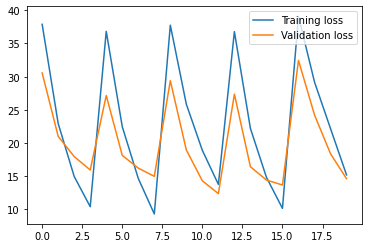

In [7]:
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=True)

In [8]:
torch.save(model.state_dict(), './model2/lstmmodel.pt')

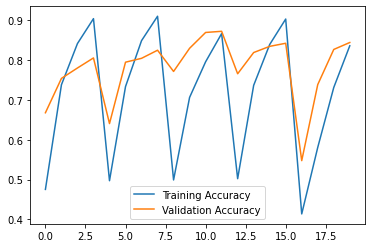

In [9]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend(frameon=True)